## Template for llama-3-instruct

In [12]:
import os
import pandas as pd
from datasets import Dataset
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

import huggingface_hub
import sys
from dotenv import load_dotenv
load_dotenv()

huggingface_hub.login(os.getenv("HUGGINGFACE_TOKEN")) 

## EDA for  for empty coloumns

## EDA for  for empty coloumns

In [67]:
def count_max_words(series):
    max_words = series.apply(lambda x: len(str(x).split())).max()
    return max_words

max_counter_df = pd.DataFrame(columns=['category', 'product_name','description','meta_info','feature_list','style_attributes', 'total max'])
for filename in os.listdir('dataset'):
    if filename.endswith(".csv"):
        df = pd.read_csv('dataset/' + filename)
        max_words_product_name = count_max_words(df['product_name'])
        max_words_description = count_max_words(df['description'])
        max_words_meta_info = count_max_words(df['meta_info'])
        # max_words_brand = count_max_words(df['brand'])
        max_words_feature_list = count_max_words(df['feature_list'])
        max_words_style_attributes = count_max_words(df['style_attributes'])
        max_words = max_words_product_name + max_words_description + max_words_meta_info + max_words_feature_list + max_words_style_attributes
        temp_dict = {
            'category': filename[:-4], 
            'product_name': max_words_product_name, 
            'description': max_words_description, 
            'meta_info': max_words_meta_info, 
            # 'brand': max_words_brand, 
            'feature_list': max_words_feature_list, 
            'style_attributes': max_words_style_attributes, 
            'total max': max_words
        }
        max_counter_df = pd.concat([max_counter_df, pd.DataFrame(temp_dict, index=[0])], ignore_index=True)


'''SHOWING ONLY EMPTY COLUMNS'''
max_counter_df

,category,product_name,description,meta_info,feature_list,style_attributes,total max
0,Dresses,89,99,169,1,169,527
1,Shirts,43,61,152,1,153,410
2,Kurtis,58,508,12,1,12,591
3,Sneakers,15,1,284,206,138,644
4,Saree,54,301,107,48,110,620
5,Jeans,70,69,164,1,165,469
6,Bathroom,28,248,535,347,284,1442
7,Earrings,15,52,237,110,225,639
8,Tshirts,66,31,87,1,104,289
9,Watches,38,623,554,384,314,1913


In [31]:
# Select the first row of the dataframe
row = df.iloc[0]

# Print each column in a separate line
for column in df.columns:
    print(f"{column}: {row[column]}")

sno: 1
product_name: Casio G-Shock Analog-Digital Silver Dial Men GM-2110D-7ADR (G1612)
description: Introducing the GM-2110D - a model based on GA The G-STEEL series based on the -2100 pointer digital dual display watch has been upgraded with a stylish metal bezel and strap texture. The octagonal stainless steel bezel is finely forged and polished to present a simple design, with a refined and powerful appearance. The case is made of highly rigid glass fiber reinforced resin and is the slimmest among all G-SHOCK dual display models. The thickness is only 11.8 mm. The combination of the metal strap and the fresh color of the copper metal dial makes it suitable for any occasion, whether for work or leisure and entertainment. In addition to the classic shades of navy and silver, there are also options in sky blue, orange or lime green. Equipped with high-brightness dual LED lights, ensuring easy reading even in the dark. ※GM-2110D-3A and GM-2110D-4A are only sold in CASIO concept stores 

## Preprocessing Dataset (Including only those with the valid output)

In [10]:
for filename in os.listdir('dataset'):
    df = pd.read_csv('dataset/' + filename)
    df = df.drop(columns=['brand'])
    new_df = pd.DataFrame(columns=df.columns)
    skip = 0
    for index, row in df.iterrows():
        i = row['style_attributes']
        i = i.replace("'", '"').encode('utf-8').decode('unicode_escape')
        try: 
            json_obj = json.loads(i)
        except:
            skip += 1
            continue
        df.at[index, 'style_attributes'] = i
        new_df = pd.concat([new_df, df.iloc[[index]]], ignore_index=True)    
    new_df.to_csv(f'dataset/{filename}', index=False)
    print(f"Saved {filename} with {skip} skipped rows out of {len(df)}")

Saved Dresses.csv with 0 skipped rows out of 7795
Saved Shirts.csv with 162 skipped rows out of 9106
Saved Kurtis.csv with 216 skipped rows out of 14031
Saved Sneakers.csv with 257 skipped rows out of 4660
Saved Saree.csv with 174 skipped rows out of 7305
Saved Jeans.csv with 158 skipped rows out of 21366
Saved Bathroom.csv with 1426 skipped rows out of 9546
Saved Earrings.csv with 683 skipped rows out of 5112
Saved Tshirts.csv with 36 skipped rows out of 5721
Saved Watches.csv with 3076 skipped rows out of 9856


#### Finding how many valid attributes are useless

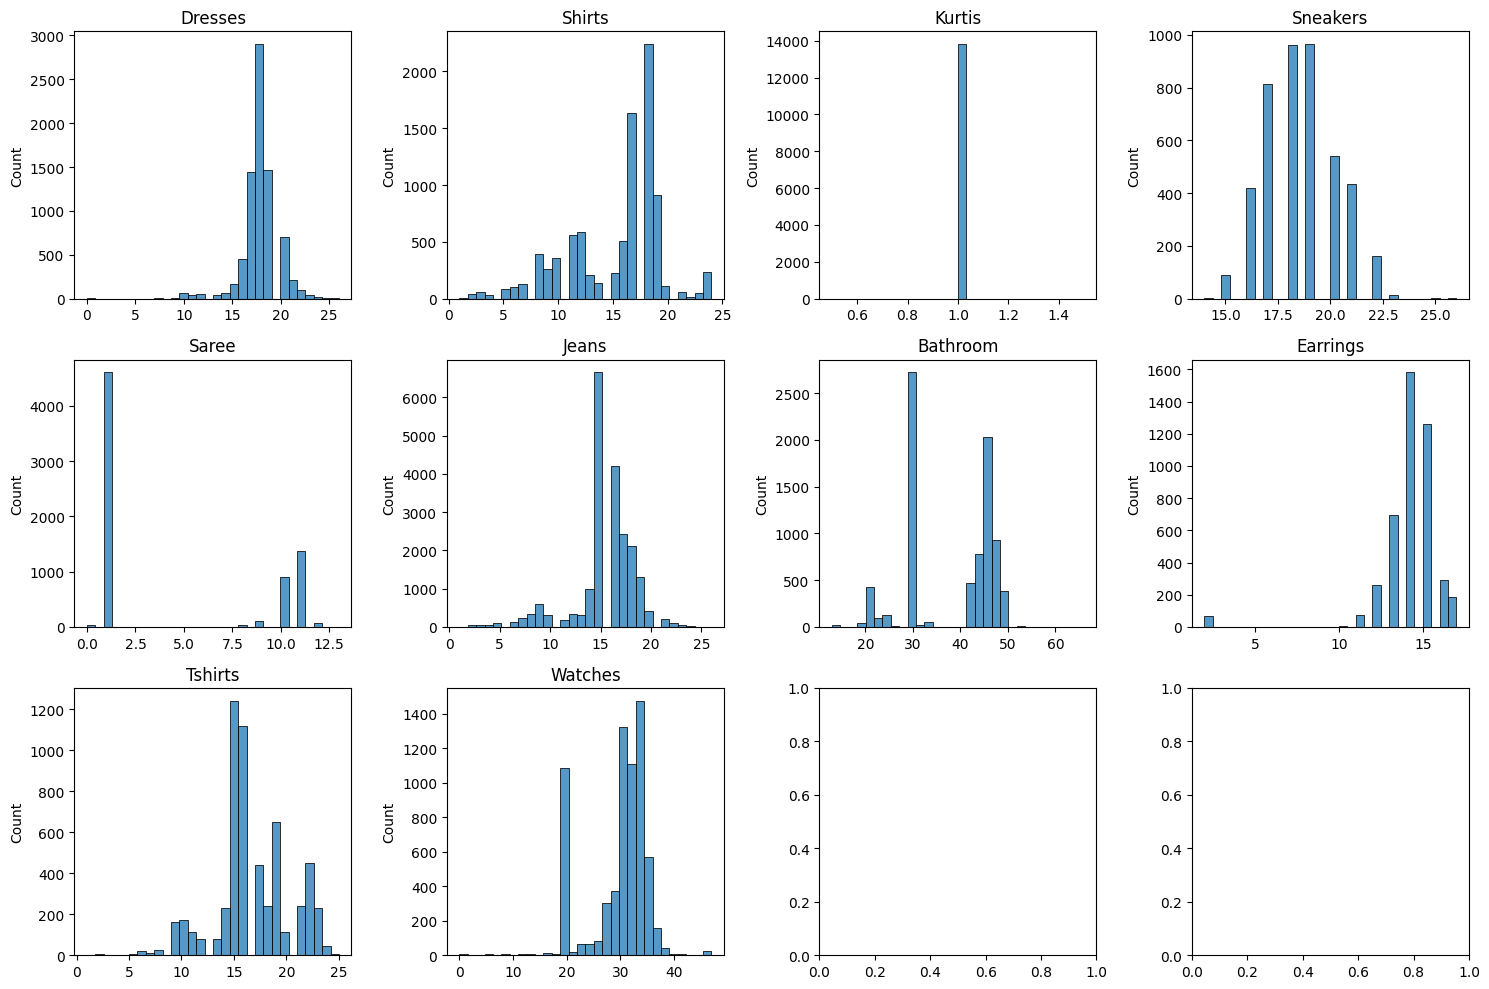

In [63]:
# Get the list of files in the dataset directory

# Create subplots with 2 columns and 5 rows
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Iterate over the first 10 files and create a subplot for each
idx = 0
for filename in os.listdir('dataset'):
    att_no_list = []
    df = pd.read_csv(f'dataset/{filename}')
    for index, row in df.iterrows():
        length = len(json.loads(row['style_attributes']))
        att_no_list.append(length)

    sns.histplot(att_no_list, kde=False, bins=30, ax=axes[idx // 4, idx % 4])
    axes[idx // 4, idx % 4].set_title(f'{filename[:-4]}')
    idx+=1

plt.tight_layout()
plt.show()


## Generating the dataset Dataset

In [13]:

prompt_instruction = "I have a {category} fashion product description I want you to find the properties and value pair which I can use in the making the ontology, please write in the key value pair in the json objects. you are allowed to omit few things which you think is not neccessory to include in the ontology"

prompt_input = ''' product_name: {product_name}
description: {description}+{meta_data}
feature_list: {feature_list}
'''

prompt_output = ""



data = {}

for filename in os.listdir("dataset"):
    cat = filename[:-4]

    df = pd.read_csv(f"dataset/{filename}")
    size = len(df)

    data[cat] = {}
    prompt_input_list = []
    for i, row in df.iterrows():
        prompt_input_list.append(prompt_input.format(
            product_name=df['product_name'][i], 
            description=df['description'][i], 
            meta_data=df['meta_info'][i], 
            feature_list=df['feature_list'][i]
        ))

    if size!=len(prompt_input_list) or size!=len(df['style_attributes']):
        print("sizes are diffrenct can not parse")
    
    data[cat] = {
        "category": [cat]*size,
        "instruction": [prompt_instruction.format(category=cat)]*size,
        "input": prompt_input_list,       
        "prompt_output": df['style_attributes'].tolist()
    }

    data[cat] = Dataset.from_dict(data[cat])

    print(f"Done for {cat}")

Done for Dresses
Done for Shirts
Done for Kurtis
Done for Sneakers
Done for Saree
Done for Jeans
Done for Bathroom
Done for Earrings
Done for Tshirts
Done for Watches


In [14]:
all_cat = []
all_instruction = []
all_input = []
all_output = []

for k, v in data.items():
    all_cat.extend(v['category'])
    all_instruction.extend(v['instruction'])
    all_input.extend(v['input'])
    all_output.extend(v['prompt_output'])
    print(f'done for {k}')


dataset_dict = {
    "category": all_cat,
    "instruction": all_instruction,
    "input": all_input, 
    "prompt_output": all_output
}


# print(f'Dataset {type(dataset)}, {dataset}')
# print(f"Dataset of cat {type(dataset['Dresses'])}, {dataset['Dresses']}")
# dataset['Dresses'][0]
dataset = Dataset.from_dict(dataset_dict)

done for Dresses
done for Shirts
done for Kurtis
done for Sneakers
done for Saree
done for Jeans
done for Bathroom
done for Earrings
done for Tshirts
done for Watches


In [15]:
dataset.push_to_hub('ImJericho/Stylumia-nxt-text2text')

Uploading the dataset shards: 100%|██████████| 1/1 [00:34<00:00, 34.68s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/ImJericho/Stylumia-nxt-text2text/commit/94e7f4d7c1073667bf5de405a284da7918dcb996', commit_message='Upload dataset', commit_description='', oid='94e7f4d7c1073667bf5de405a284da7918dcb996', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ImJericho/Stylumia-nxt-text2text', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ImJericho/Stylumia-nxt-text2text'), pr_revision=None, pr_num=None)

In [9]:
dataset['prompt_output']

['{"Care instructions": "Line dry, Only non-chlorine bleach when needed, Machine wash at 40Â°, Medium iron, Can be dry cleaned", "Composition": "Polyester 100%", "Description": "Cream/Light pink, Flower", "Sleeve Length": "Sleeveless", "Size": "XS :- Width: 80 cm, Length: 1.35 m, S :- Width: 88 cm, Length: 1.37 m, M :- Width: 96 cm, Length: 1.38 m, L :- Width: 1.04 m, Length: 1.40 m, XL :- Width: 1.16 m, Length: 1.41 m", "Material": "Satin", "Fit": "Loose fit", "Country of production": "China", "Price (MRP)": "Rs. 2,699.00 incl. of all taxes", "Date of manufacture": "N/A", "Length": "Long", "Additional material information": "Recycled polyester 100%", "Style": "One-shoulder", "Common generic name": "Dress", "Net Quantity": "1 N", "Date of import": "08-2024"}',
 '{"Concept": "H&M EDITION", "Care instructions": "Line dry, Only non-chlorine bleach when needed, Machine wash at 40Â°, Medium iron, Can be dry cleaned, Wash with similar colours", "Composition": "Shell: Polyester 100%, Lining: 